In [1]:
import pandas as pd
import pyarrow.parquet as pq
from functools import reduce
import numpy as np
import tarfile
import matplotlib.pyplot as plt
import matplotlib.dates as mdates


In [2]:
BASE_FEATURES = {
    "logics" : [
        "Tot_qpompe", "Tot_chiller", "Tot_cdz"
        ], 
    "schneider" : [
        "Temp_mandata", "Temp_ritorno",
        "Portata_attiva", "Pos_valvola1",
        "Rif_inverter", "Set_temperatura"
    ], 
    "vertiv": [
        "Return_Air_Temperature", "Supply_Air_Temperature", "Fan_Speed",
        "Compressor_Utilization", "Free_Cooling_Status", "Free_Cooling_Valve_Open_Position"
    ]
}

with tarfile.open("data/marconi/22-06.tar", "r:*") as tf:
    m = tf.getmembers()
    for mem in m:
        print(mem.name)

year_month=22-06
year_month=22-06/plugin=job_table
year_month=22-06/plugin=job_table/metric=job_info_marconi100
year_month=22-06/plugin=job_table/metric=job_info_marconi100/a_0.parquet
year_month=22-06/plugin=slurm_pub
year_month=22-06/plugin=slurm_pub/metric=s21.totals.total_nodes_mixed
year_month=22-06/plugin=slurm_pub/metric=s21.totals.total_nodes_mixed/a_0.parquet
year_month=22-06/plugin=slurm_pub/metric=s21.jobs.tot_nodes
year_month=22-06/plugin=slurm_pub/metric=s21.jobs.tot_nodes/a_0.parquet
year_month=22-06/plugin=slurm_pub/metric=s21.totals.total_nodes_config
year_month=22-06/plugin=slurm_pub/metric=s21.totals.total_nodes_config/a_0.parquet
year_month=22-06/plugin=slurm_pub/metric=s21.jobs.tot_gpus
year_month=22-06/plugin=slurm_pub/metric=s21.jobs.tot_gpus/a_0.parquet
year_month=22-06/plugin=slurm_pub/metric=s21.totals.gpus_idle
year_month=22-06/plugin=slurm_pub/metric=s21.totals.gpus_idle/a_0.parquet
year_month=22-06/plugin=slurm_pub/metric=s21.totals.cpus_config
year_month=22

In [3]:
def plot_series_list(series_list, labels=None, title="Time Series Comparison",
                     figsize=(10,4), alpha=0.8):
    """
    Plot multiple pandas Series (each with a DatetimeIndex) on one figure.

    Parameters
    ----------
    series_list : list[pd.Series]
        Each Series must be indexed by timestamps and contain numeric values.
    labels : list[str], optional
        Labels for each series (defaults to Series.name or 'series_i').
    title : str
        Plot title.
    figsize : tuple
        Figure size (width, height).
    alpha : float
        Line transparency (0–1).
    """
    plt.figure(figsize=figsize)

    for i, s in enumerate(series_list):
        if not isinstance(s, pd.Series):
            raise TypeError(f"Item {i} is {type(s)}, expected a pandas Series.")
        if s.empty:
            print(f"⚠️ Series {i} is empty — skipping.")
            continue

        label = None
        if labels is not None and i < len(labels):
            label = labels[i]
        else:
            label = s.name or f"series_{i}"
        start_time = s.index.min()
        end_time   = start_time + pd.Timedelta(days=1)

        s = s[start_time:end_time]

        plt.plot(s.index, s.values, label=label, alpha=alpha)

    plt.title(title)
    plt.xlabel("Timestamp")
    plt.ylabel("Value")
    plt.legend()
    plt.grid(True, linestyle="--", alpha=0.5)
    plt.tight_layout()
    plt.show()


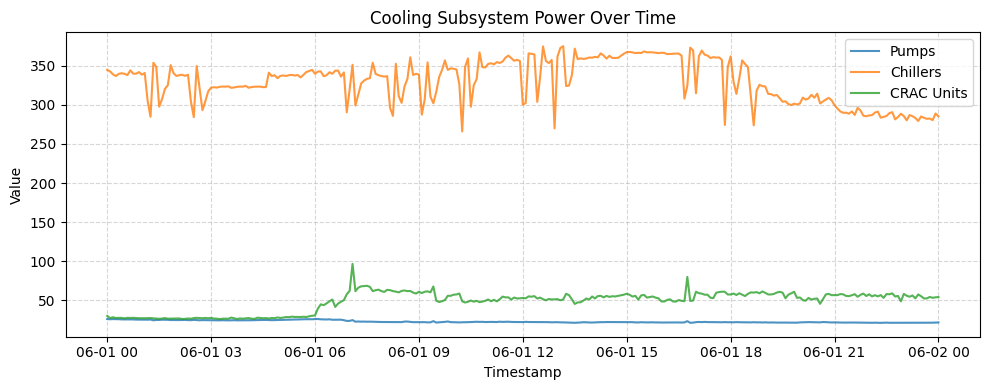

In [4]:
##Logics Data Cleaning
logics_dfs = []
cols = []
with tarfile.open("data/marconi/22-06.tar", "r:*") as tf:
    for metric in BASE_FEATURES["logics"]:
        m = tf.getmember(f"year_month=22-06/plugin=logics_pub/metric={metric}/a_0.parquet")
        s = pq.read_table(tf.extractfile(m)).to_pandas()

        col_name = f"{metric} value"
        cols.append(col_name)
        s = s.rename(columns={'value': col_name})

        s['timestamp'] = pd.to_datetime(s['timestamp'], utc=True).dt.floor('5min')
        s = s.groupby('timestamp')[col_name].mean()
        logics_dfs.append(s)
plot_series_list(logics_dfs, ["Pumps", "Chillers", "CRAC Units"], title="Cooling Subsystem Power Over Time")
logics_fin = reduce(lambda left, right: pd.merge(left, right, on='timestamp'), logics_dfs)
logics_fin['value'] = logics_fin[cols].sum(axis=1)


In [5]:
##Schnieder Data Cleaning
schneider_dfs = []
with tarfile.open("data/marconi/22-06.tar", "r:*") as tf:
    for metric in BASE_FEATURES["schneider"]:
        m = tf.getmember(f"year_month=22-06/plugin=schneider_pub/metric=PLC_PLC_Q101.{metric}/a_0.parquet")
        s = pq.read_table(tf.extractfile(m)).to_pandas()

        col_name = f"{metric} value"
        s = s.rename(columns={'value': col_name})

        s['timestamp'] = pd.to_datetime(s['timestamp'], utc=True).dt.floor('5min')
        s = s.groupby('timestamp')[col_name].mean()
        schneider_dfs.append(s)
schneider_fin = reduce(lambda left, right: pd.merge(left, right, on='timestamp'), schneider_dfs)

rename_map = {
    "Temp_mandata value": "supply_temp_C",
    "Temp_ritorno value": "return_temp_C",
    "Portata_attiva value": "flow_rate_m3h",
    "Pos_valvola1 value": "valve1_pos_pct",
    "Rif_inverter value": "pump_inverter_pct",
    "Set_temperatura value": "temp_setpoint_C",
}

schneider_fin = schneider_fin.rename(columns=rename_map)
schneider_fin.head()

,supply_temp_C,return_temp_C,flow_rate_m3h,valve1_pos_pct,pump_inverter_pct,temp_setpoint_C
timestamp,,,,,,
2022-06-01 00:00:00+00:00,158.625000,217.291667,1128.375000,8188.250000,6589.791667,160.0
2022-06-01 00:05:00+00:00,158.566667,217.500000,1118.700000,8178.700000,6472.233333,160.0
2022-06-01 00:10:00+00:00,158.769231,217.423077,1132.115385,8097.576923,6586.653846,160.0
2022-06-01 00:15:00+00:00,158.791667,217.708333,1126.750000,8063.958333,6538.583333,160.0
2022-06-01 00:20:00+00:00,158.500000,217.115385,1127.500000,7976.115385,6535.461538,160.0


In [6]:
##Vertiv Data Cleaning
vertiv_dfs = []
with tarfile.open("data/marconi/22-06.tar", "r:*") as tf:
    for metric in BASE_FEATURES["vertiv"]:
        m = tf.getmember(f"year_month=22-06/plugin=vertiv_pub/metric={metric}/a_0.parquet")
        s = pq.read_table(tf.extractfile(m)).to_pandas()

        col_name = f"{metric} value"
        s = s.rename(columns={'value': col_name})

        s['timestamp'] = pd.to_datetime(s['timestamp'], utc=True).dt.floor('5min')
        s = s.groupby('timestamp')[col_name].mean()
        vertiv_dfs.append(s)
vertiv_fin = reduce(lambda left, right: pd.merge(left, right, on='timestamp'), vertiv_dfs)

vertiv_fin.head()

,Return_Air_Temperature value,Supply_Air_Temperature value,Fan_Speed value,Compressor_Utilization value,Free_Cooling_Status value,Free_Cooling_Valve_Open_Position value
timestamp,,,,,,
2022-06-01 00:00:00+00:00,24.763889,21.264444,60.000000,9.522223,0.294444,11.855556
2022-06-01 00:05:00+00:00,24.814445,21.369444,60.194443,8.333333,0.333333,15.588889
2022-06-01 00:10:00+00:00,24.821114,21.261110,60.611111,8.333333,0.333333,15.966666
2022-06-01 00:15:00+00:00,24.807224,21.221111,60.338890,8.333333,0.333333,15.761111
2022-06-01 00:20:00+00:00,24.787779,21.183332,60.000000,8.333333,0.333333,15.383333


In [7]:
p1 = pd.merge(vertiv_fin, schneider_fin, on='timestamp')
merged = pd.merge(p1, logics_fin, on='timestamp')


In [8]:
##feature engineering
df = merged.copy()

# === 1️⃣ Basic thermal deltas and control gaps ===
df["deltaT_air"]   = df["Return_Air_Temperature value"] - df["Supply_Air_Temperature value"]
df["deltaT_water"] = df["return_temp_C"] - df["supply_temp_C"]

# difference between measured and setpoint (for air & water loops)
df["air_temp_gap"]   = df["Return_Air_Temperature value"] - df["temp_setpoint_C"]
df["water_temp_gap"] = df["supply_temp_C"] - df["temp_setpoint_C"]

# === 2️⃣ Flow × ΔT proxy (thermal load of water loop) ===
# (proportional to Q = ρ * c_p * flow * ΔT)
df["flow_dT_product"] = df["flow_rate_m3h"] * df["deltaT_water"]

# === 3️⃣ Normalize and power-law scaling ===
df["fan_speed_frac"]     = df["Fan_Speed value"] / 100.0
df["pump_inverter_frac"] = df["pump_inverter_pct"] / 100.0

# Fan/pump cube law (power ~ speed³)
df["fan_power_est"]  = df["fan_speed_frac"] ** 3
df["pump_power_est"] = df["pump_inverter_frac"] ** 3

# === 4️⃣ Free-cooling indicators ===
df["freecool_active"] = (df["Free_Cooling_Status value"] > 0).astype(int)
df["free_valve_frac"] = df["Free_Cooling_Valve_Open_Position value"] / 100.0

# synergy term — how open valve interacts with free-cooling mode
df["freecool_intx"] = df["freecool_active"] * df["free_valve_frac"]

# === 5️⃣ Ratios / efficiencies ===
# cooling effectiveness: air ΔT / water ΔT (avoid div by 0)
df["air_water_ratio"] = df["deltaT_air"] / (df["deltaT_water"].replace(0, np.nan))
# valve/pump coordination
df["valve_pump_corr"] = df["valve1_pos_pct"] / (df["pump_inverter_pct"].replace(0, np.nan))

# === 6️⃣ Temporal context features ===
df["hour"] = df.index.hour
df["dayofweek"] = df.index.dayofweek
df["hour_sin"] = np.sin(2 * np.pi * df["hour"] / 24)
df["hour_cos"] = np.cos(2 * np.pi * df["hour"] / 24)




# === 9️⃣ Drop any temporary NaN rows introduced by lags if needed ===
df = df.dropna().copy()


print(f"{df.shape[0]} rows × {df.shape[1]} columns after feature engineering")


8226 rows × 34 columns after feature engineering


In [9]:
dt_hours = df.index.to_series().diff().dt.total_seconds() / 3600.0
gap_idx  = dt_hours.idxmax()

split_time = gap_idx
training = df.loc[df.index <  split_time].copy()
testing = df.loc[df.index >= split_time].copy()

# val_end  = testing.index.min() + pd.Timedelta(days=2)
# val  = testing.loc[testing.index <  val_end].copy()   
# test = testing.loc[testing.index >= val_end].copy()   

In [10]:
def createTargets(d): 
    d = d.dropna()
    y = d["value"]
    x = d.drop(columns=["Tot_cdz value", "Tot_qpompe value", "Tot_chiller value", "value"])
    return x, y

In [11]:
xtrain, ytrain = createTargets(training)
# xval, yval = createTargets(val)
xtest, ytest = createTargets(testing)

In [12]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LassoCV, RidgeCV, ElasticNetCV
from sklearn.metrics import mean_squared_error, r2_score
import statsmodels.api as sm


In [13]:
#Simple LinReg
xtrain_sm = sm.add_constant(xtrain)
xtest_sm  = sm.add_constant(xtest)

# Fit OLS model
model = sm.OLS(ytrain, xtrain_sm).fit()

# Predict on test set
y_test_preds = model.predict(xtest_sm)
r2 = r2_score(ytest, y_test_preds)
rmse = np.sqrt(mean_squared_error(ytest, y_test_preds))

print(f"Validation Results:")
print(f"  R²   = {r2:.4f}")
print(f"  RMSE = {rmse:.4f}")

Validation Results:
  R²   = 0.6727
  RMSE = 28.2359


In [16]:
#Scaling
scaler = StandardScaler()
xtrain_scaled = scaler.fit_transform(xtrain)
xtest_scaled  = scaler.transform(xtest)

In [21]:
from sklearn.exceptions import ConvergenceWarning
import warnings

warnings.filterwarnings("ignore", category=ConvergenceWarning)


In [22]:
##Lasso
lasso_cv = LassoCV(
    alphas=np.logspace(-3, 1, 100),
    cv=5,
    n_jobs=-1,
    max_iter=20000,      # 4× more iterations
    tol=1e-4,            # slightly looser tolerance
    selection='random'   # helps with convergence
)
lasso_cv.fit(xtrain_scaled, ytrain)

y_pred_lasso = lasso_cv.predict(xtest_scaled)
mse_lasso = mean_squared_error(ytest, y_pred_lasso)
r2_lasso  = r2_score(ytest, y_pred_lasso)

print(f"LASSO Test MSE: {mse_lasso:.2f}")
print(f"LASSO Test R²:  {r2_lasso:.4f}")

LASSO Test MSE: 792.85
LASSO Test R²:  0.6745


In [23]:
##Ridge
ridge_cv = RidgeCV(alphas=np.logspace(-3, 3, 100), cv=5)
ridge_cv.fit(xtrain_scaled, ytrain)

y_pred_ridge = ridge_cv.predict(xtest_scaled)
mse_ridge = mean_squared_error(ytest, y_pred_ridge)
r2_ridge  = r2_score(ytest, y_pred_ridge)

print(f"Ridge Test MSE: {mse_ridge:.2f}")
print(f"Ridge Test R²:  {r2_ridge:.4f}")


Ridge Test MSE: 844.99
Ridge Test R²:  0.6531


In [24]:
enet_cv = ElasticNetCV(
    alphas=np.logspace(-3, 1, 100),
    l1_ratio=[.1, .3, .5, .7, .9],
    cv=5,
    n_jobs=-1,
    max_iter=5000
)
enet_cv.fit(xtrain_scaled, ytrain)

y_pred_enet = enet_cv.predict(xtest_scaled)
mse_enet = mean_squared_error(ytest, y_pred_enet)
r2_enet  = r2_score(ytest, y_pred_enet)

print(f"ElasticNet Test MSE: {mse_enet:.2f}")
print(f"ElasticNet Test R²:  {r2_enet:.4f}")


Best α (ElasticNet): 0.0792
Best L1 ratio:       0.10
ElasticNet Test MSE: 838.67
ElasticNet Test R²:  0.6557


In [ ]:
summary_table = model.summary2().tables[1]
summary_table = summary_table.sort_values("P>|t|")
print("\nTop features by significance (lowest p-values):")
summary_table.head(10)


In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(14,5))

# Plot directly using datetime index
plt.plot(ytest.index, ytest.values, label="Actual", alpha=0.8)
plt.plot(ytest.index, y_test_preds, label="Predicted", alpha=0.8)

plt.legend()
plt.title("Test Set: Actual vs Predicted P_IT")
plt.xlabel("Timestamp")
plt.ylabel("Power (kW)")

# Rotate and format datetime ticks
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [ ]:
# Get coefficients as a Series
coefs = pd.Series(model.params, index=xtrain_sm.columns)

# Extract time-of-day coefficients safely
beta_sin = coefs.get('hour_sin', 0.0)
beta_cos = coefs.get('hour_cos', 0.0)

# Compute hour angles
hours = np.arange(24)
hour_sin = np.sin(2 * np.pi * hours / 24.0)
hour_cos = np.cos(2 * np.pi * hours / 24.0)

# Learned diurnal contribution (relative kW)
hour_effect = beta_sin * hour_sin + beta_cos * hour_cos

# Plot
plt.figure(figsize=(8,3))
plt.plot(hours, hour_effect, marker='o')
plt.xticks(range(0,24,2))
plt.xlabel("Hour of day")
plt.ylabel("Diurnal contribution (kW, relative)")
plt.title("Learned Time-of-Day Effect on P_Cooling")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()
